## Generated graph locally.

In [64]:
# Import the required modules

import networkx as nx
import nx_arangodb as nxadb

from arango import ArangoClient

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import re

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool

In [65]:
# Connect to the ArangoDB database 
# TODO: Configure your credentials here!
db = ArangoClient(hosts="https://010385603c90.arangodb.cloud:8529").db(username="root", password="test", verify=True)
print(db)

<StandardDatabase _system>


In [66]:
# Required Libraries
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Load and clean the data
csv_path = 'vegetables.csv'  # Update path accordingly
df = pd.read_csv(csv_path, encoding='ISO-8859-1')

In [67]:
def parse_month(date_str):
    month_map = {
        'Jan': 'January', 'Feb': 'February', 'Mar': 'March', 'Apr': 'April',
        'May': 'May', 'Jun': 'June', 'Jul': 'July', 'Aug': 'August',
        'Sep': 'September', 'Oct': 'October', 'Nov': 'November', 'Dec': 'December'
    }
    try:
        if '-' in date_str:
            month_part = date_str.split('-')[-1][:3]
        elif '/' in date_str:
            month_part = date_str.split('/')[1][:3]
        else:
            month_part = date_str[:3]
        return month_map.get(month_part, None)
    except:
        return None

# Apply parsing and clean DataFrame
df['clean_sowing_month'] = df['sowing_month'].apply(parse_month)
df.dropna(subset=['clean_sowing_month'], inplace=True)

In [68]:
#  Prepare data for Graph
edges_data = []

for _, row in df.iterrows():
    sowing_month = row['clean_sowing_month']
    harvest_month = row['Approx_Month to Harvest'].replace('*', '').strip()
    vegetable = row['Sowing_Time_vegetables '].strip()

    edges_data.append((sowing_month, harvest_month, vegetable))


G = nx.DiGraph()

# Populate the graph with nodes and edges
for sow_month, harv_month, veg in edges_data:
    G.add_node(sow_month)
    G.add_node(harv_month)

    if G.has_edge(sow_month, harv_month):
        G[sow_month][harv_month]['weight'] += 1
        G[sow_month][harv_month]['vegetables'].append(veg)
    else:
        G.add_edge(sow_month, harv_month, weight=1, vegetables=[veg])

In [69]:
print(G)

DiGraph with 9 nodes and 10 edges


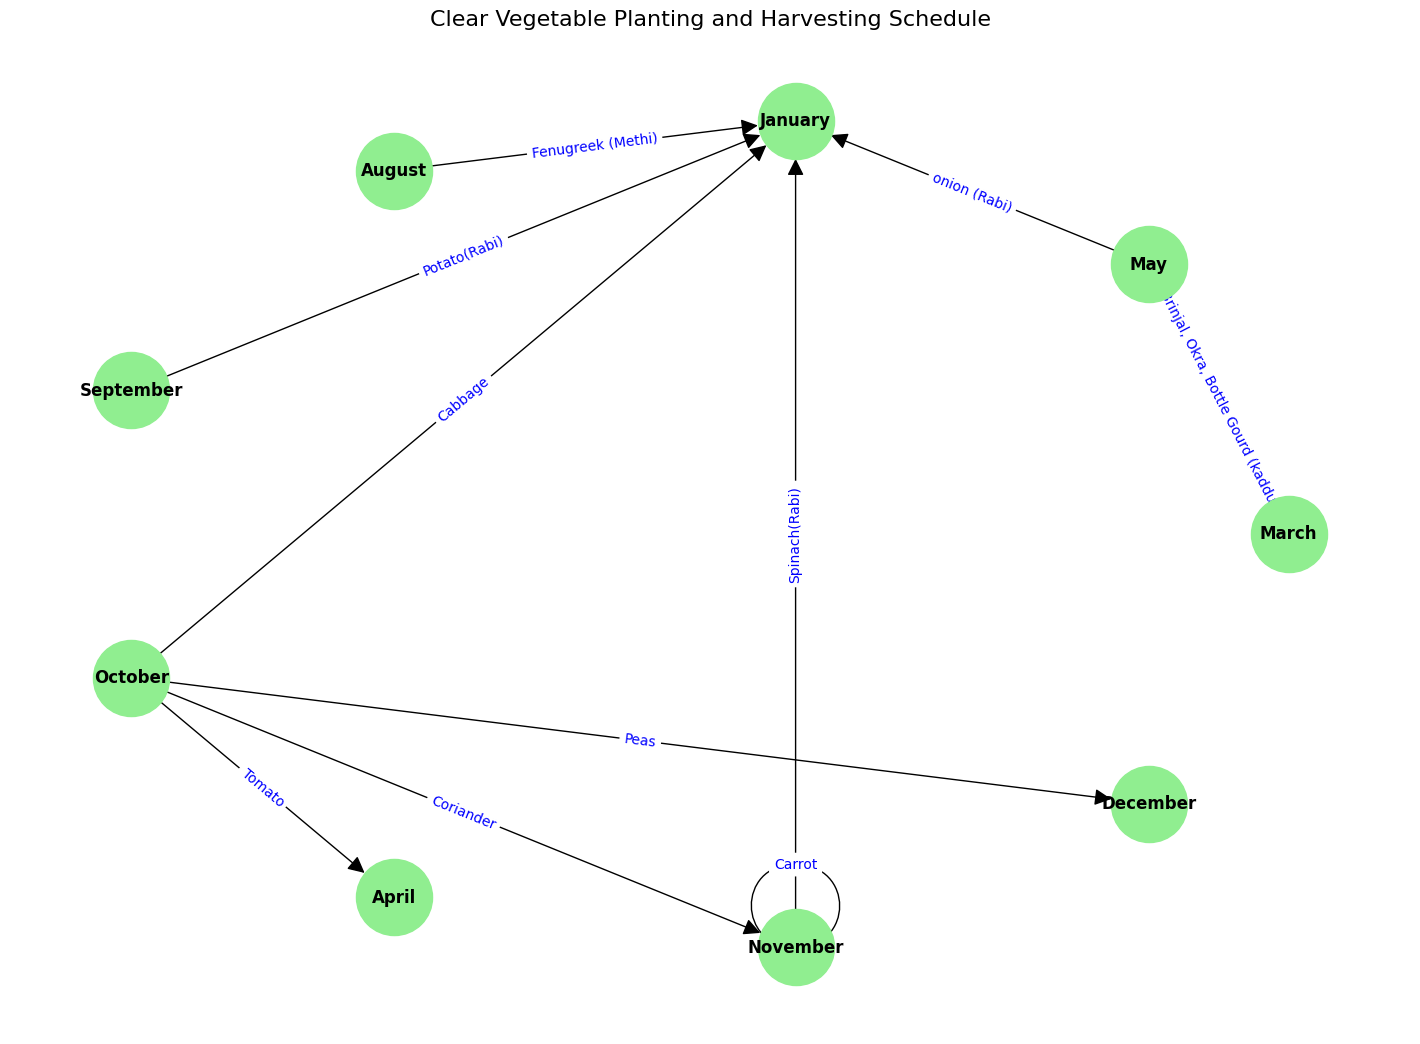

In [71]:
# Step 4: Visualize the graph clearly
plt.figure(figsize=(14, 10))
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightgreen', arrowsize=25, font_size=12, font_weight='bold')
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels={(u, v): ', '.join(d['vegetables']) for u, v, d in G.edges(data=True)},
    font_color='blue'
)

plt.title('Clear Vegetable Planting and Harvesting Schedule', fontsize=16)
plt.show()

## 2. Re-connect to the same Graph from remote non-relational database arangodb


In [72]:
G_adb = nxadb.Graph(name="vegetables", db=db)

print(G_adb)

[02:42:21 +0000] [INFO]: Graph 'vegetables' exists.
[02:42:21 +0000] [INFO]: Default node type set to 'vegetables_node'


Graph named 'vegetables' with 9 nodes and 10 edges


### Build the Agentic App with LangChain & LangGraph

In [73]:
#  Define the llm object
# Note: You can use any llm you want. We will be using OpenAI for example purposes.
import os
os.environ["OPENAI_API_KEY"] = "fC_u-TgyyGtW2rgA"
llm = ChatOpenAI(temperature=0, model_name="gpt-4o-mini-2024-07-18")
llm.invoke("hello!")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 9, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None}, id='run-3f58fe8d-3a37-4df9-8a3f-3dec61134756-0', usage_metadata={'input_tokens': 9, 'output_tokens': 10, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [ ]:
!pip install -U langchain-openai


In [74]:
import re
from langchain.chat_models import ChatOpenAI
from langchain_openai import ChatOpenAI

# Change .call() to .invoke()
answer = text_to_aql_to_text.invoke(sample_query)

from langchain.tools import tool
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_community.graphs.arangodb_graph import ArangoGraph
from arango import ArangoClient



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH vegetables_node, vegetables_node_to_vegetables_node
FOR v, e IN 1..1 OUTBOUND 'vegetables_node/March' GRAPH 'vegetables'
FILTER e._from == 'vegetables_node/March'
RETURN e.vegetables

AQL Result:
[['Brinjal']]

> Finished chain.


In [75]:
# 1. Connect to ArangoDB
client = ArangoClient(hosts="https://010385603c90.arangodb.cloud:8529")
db = client.db("_system", username="root", password="test", verify=False)

# 2. Initialize the ArangoGraph object for your 'vegetables' graph
arango_graph = ArangoGraph(db=db)
arango_graph.graph_name = "vegetables"  # Set the graph name manually

### 4. Define the Text to AQL Tool

In [76]:
# 3. Define the Text-to-AQL tool using LangChain's ArangoGraphQAChain
@tool
def text_to_aql_to_text(query: str) -> str:
    """
    This tool translates a natural language query into AQL,
    executes the query on the ArangoDB 'vegetables' graph, and returns a natural language summary.
    """
    llm = ChatOpenAI(temperature=0, model_name="gpt-4")
    
    # Create the AQL chain using the provided ArangoGraph instance
    chain = ArangoGraphQAChain.from_llm(
        llm=llm,
        graph=arango_graph,
        verbose=True,
        allow_dangerous_requests=True
    )
    
    result = chain.invoke(query)
    return str(result["result"])

# 4. Test the tool with a sample query
sample_query = "What vegetables can I sow in January?"
answer = text_to_aql_to_text(sample_query)
print("Answer:", answer)




> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH vegetables_node, vegetables_node_to_vegetables_node
FOR v, e IN 1..1 OUTBOUND 'vegetables_node/January' vegetables_node_to_vegetables_node
RETURN e.vegetables

AQL Result:
[]

> Finished chain.
Answer: Summary:
There are no specific vegetables recommended for sowing in January according to the database.


### September:

In [77]:
#  Test the tool with a sample query
sample_query = "What vegetables can I sow in September?"
answer = text_to_aql_to_text(sample_query)
print("Answer:", answer)



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH vegetables_node, vegetables_node_to_vegetables_node
FOR v, e IN 1..1 OUTBOUND 'vegetables_node/September' vegetables_node_to_vegetables_node
RETURN e.vegetables

AQL Result:
[['Potato(Rabi)']]

> Finished chain.
Answer: The vegetables that you can sow in September include Potato(Rabi).


In [20]:
#  Test the tool with a sample query
sample_query = "What vegetables can I sow in September?"
answer = text_to_aql_to_text(sample_query)
print("Answer:", answer)



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH vegetables_node, vegetables_node_to_vegetables_node
FOR v IN vegetables_node
    FILTER v._key == 'September'
    FOR e IN vegetables_node_to_vegetables_node
        FILTER e._from == v._id
        RETURN e.vegetables

AQL Result:
[['Potato(Rabi)']]

> Finished chain.
Answer: In September, you can sow the Rabi variety of Potato.


In [21]:
for edge in G.edges(data=True):
    if edge[0] == "September":
        print(edge)

('September', 'January', {'weight': 1, 'vegetables': ['Potato(Rabi)']})


In [78]:
#  Test the tool with a sample query
sample_query = "What is the best time to sow carrots?"
answer = text_to_aql_to_text(sample_query)
print("Answer:", answer)



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH vegetables_node, vegetables_node_to_vegetables_node
FOR v, e IN 1..1 ANY 'vegetables_node/carrots' vegetables_node_to_vegetables_node
SORT e.weight DESC
LIMIT 1
RETURN v.label

AQL Result:
[]

> Finished chain.
Answer: Based on the data available, there is no specific time recommended for sowing carrots.


In [108]:
for edge in G.edges(data=True):
    if edge[0] == "November":
        print(edge)

('November', 'November', {'weight': 1, 'vegetables': ['Carrot']})
('November', 'January', {'weight': 1, 'vegetables': ['Spinach(Rabi)']})


In [25]:
# confirm that all nodes are present
result = db.aql.execute("""
    FOR v IN vegetables_node
        RETURN v

""")
print(list(result))

[{'_key': 'March', '_id': 'vegetables_node/March', '_rev': '_jVrER_S---', 'label': 'March'}, {'_key': 'May', '_id': 'vegetables_node/May', '_rev': '_jVrERr6---', 'label': 'May'}, {'_key': 'August', '_id': 'vegetables_node/August', '_rev': '_jVrEUBG---', 'label': 'August'}, {'_key': 'September', '_id': 'vegetables_node/September', '_rev': '_jVrEV4W---', 'label': 'September'}, {'_key': 'April', '_id': 'vegetables_node/April', '_rev': '_jVrEYcW---', 'label': 'April'}, {'_key': 'October', '_id': 'vegetables_node/October', '_rev': '_jVrEcZu---', 'label': 'October'}, {'_key': 'December', '_id': 'vegetables_node/December', '_rev': '_jVrEdGa---', 'label': 'December'}, {'_key': 'November', '_id': 'vegetables_node/November', '_rev': '_jVrEfcC---', 'label': 'November'}, {'_key': 'January', '_id': 'vegetables_node/January', '_rev': '_jVrEfr----', 'label': 'January'}]


In [ ]:
# to validate the edges.
result = db.aql.execute("""
    FOR e IN vegetables_node_to_vegetables_node
        RETURN e
""")
print(list(result))

In [24]:
# Verify September Node:
result = db.aql.execute("""
    FOR v IN vegetables_node
        FILTER v._key == "September"
            RETURN v
""")
print(list(result))

[{'_key': 'September', '_id': 'vegetables_node/September', '_rev': '_jVrEV4W---', 'label': 'September'}]


In [23]:
# Verify Edge Connectivity:
result = db.aql.execute("""
    FOR e IN vegetables_node_to_vegetables_node
    FILTER e._from == "vegetables_node/September"
    RETURN e
""")
print(list(result))

[{'_key': '45289', '_id': 'vegetables_node_to_vegetables_node/45289', '_from': 'vegetables_node/September', '_to': 'vegetables_node/January', '_rev': '_jVrEXD----', 'weight': 2, 'vegetables': ['Potato(Rabi)']}]


### August:

In [79]:
# Test the tool with a sample query
sample_query = "What vegetables can I sow in August?"
answer = text_to_aql_to_text(sample_query)
print("Answer:", answer)



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH vegetables_node, vegetables_node_to_vegetables_node
FOR v, e IN 1..1 OUTBOUND 'vegetables_node/August' vegetables_node_to_vegetables_node
RETURN e.vegetables

AQL Result:
[['Fenugreek (Methi)']]

> Finished chain.
Answer: In August, you can sow Fenugreek (Methi).


In [27]:
for edge in G.edges(data=True):
    if edge[0] == "August":
        print(edge)

('August', 'January', {'weight': 1, 'vegetables': ['Fenugreek (Methi)']})


In [29]:
# Verify September Node:
result = db.aql.execute("""
    FOR v IN vegetables_node
        FILTER v._key == "August"
            RETURN v
""")
print(list(result))

[{'_key': 'August', '_id': 'vegetables_node/August', '_rev': '_jVrEUBG---', 'label': 'August'}]


In [28]:
# Verify Edge Connectivity:
result = db.aql.execute("""
    FOR e IN vegetables_node_to_vegetables_node
    FILTER e._from == "vegetables_node/August"
    RETURN e
""")
print(list(result))

[{'_key': '45254', '_id': 'vegetables_node_to_vegetables_node/45254', '_from': 'vegetables_node/August', '_to': 'vegetables_node/January', '_rev': '_jVrEVLu---', 'weight': 2, 'vegetables': ['Fenugreek (Methi)']}]


### October:

In [30]:
#  Test the tool with a sample query
sample_query = "What vegetables can I sow in October?"
answer = text_to_aql_to_text(sample_query)
print("Answer:", answer)



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH vegetables_node, vegetables_node_to_vegetables_node
FOR v IN vegetables_node
  FILTER v._key == 'October'
  FOR e IN vegetables_node_to_vegetables_node
    FILTER e._from == v._id
    RETURN e.vegetables

AQL Result:
[['Tomato'], ['Cabbage'], ['Coriander'], ['Peas']]

> Finished chain.
Answer: The vegetables you can sow in October include Tomato, Cabbage, Coriander, and Peas.


### November:

In [37]:
#  Test the tool with a sample query
sample_query = "What vegetables can I sow in November?"
answer = text_to_aql_to_text(sample_query)
print("Answer:", answer)



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH vegetables_node, vegetables_node_to_vegetables_node
FOR v, e IN 1..1 OUTBOUND 'vegetables_node/November' vegetables_node_to_vegetables_node
RETURN e.vegetables

AQL Result:
[['Spinach(Rabi)'], ['Carrot']]

> Finished chain.
Answer: The vegetables you can sow in November include Spinach(Rabi) and Carrot.


In [101]:
for edge in G.edges(data=True):
    if edge[0] == "November":
        print(edge)

In [36]:
# Verify Edge Connectivity:
result = db.aql.execute("""
    FOR e IN vegetables_node_to_vegetables_node
    FILTER e._from == "vegetables_node/March"
    RETURN e
""")
print(list(result))

[{'_key': '45184', '_id': 'vegetables_node_to_vegetables_node/45184', '_from': 'vegetables_node/March', '_to': 'vegetables_node/May', '_rev': '_jVrERdC---', 'weight': 6, 'vegetables': ['Brinjal']}]


In [37]:
print(G)

DiGraph with 9 nodes and 10 edges


## Text → NetworkX Approach


In [81]:
import networkx as nx
from langchain_openai import ChatOpenAI
from langchain.tools import tool

# Assuming G is your already populated NetworkX graph
@tool
def text_to_nx_algorithm_to_text(query: str) -> str:
    """
    This tool generates Python/NetworkX code from GPT-4, 
    executes it on the existing G graph, and returns the result as text.
    Supports a variety of queries related to vegetable sowing and harvesting.
    """

    query = query.lower().strip()

    # Case 1: Find months with the largest variety of vegetables to sow and harvest
    if "largest variety of vegetables to sow" in query and "harvest" in query:
        sow_variety = {}
        harvest_variety = {}

        for u, v, data in G.edges(data=True):
            vegetables = data.get("vegetables", [])
            if u not in sow_variety:
                sow_variety[u] = set()
            sow_variety[u].update(vegetables)

            if v not in harvest_variety:
                harvest_variety[v] = set()
            harvest_variety[v].update(vegetables)

        max_sow_month = max(sow_variety, key=lambda k: len(sow_variety[k]))
        max_harvest_month = max(harvest_variety, key=lambda k: len(harvest_variety[k]))

        return (
            f"The month with the largest variety of vegetables to sow is {max_sow_month} "
            f"and to harvest is {max_harvest_month}."
        )
    
    # Case 2: Find the months to sow a specific vegetable
    elif "in which month can i sow" in query:
        vegetable_name = query.split("sow")[-1].strip().replace("?", "")
        sow_months = []

        for u, v, data in G.edges(data=True):
            # Normalize and check for partial matches in vegetable names
            veg_list = [veg.lower() for veg in data.get("vegetables", [])]
            if vegetable_name.lower() in veg_list or any(vegetable_name.lower() in veg for veg in veg_list):
                sow_months.append(u)
        
        if sow_months:
            return f"You can sow {vegetable_name} in the following months: {', '.join(set(sow_months))}."
        else:
            return f"No specific month found for sowing {vegetable_name}."

    # Case 3: Determine the harvest month if sown in a specific month
    elif "if sown in" in query and "when to harvest" in query:
        sow_month = query.split("sown in")[-1].strip().replace("?", "")
        harvest_months = []

        for u, v, data in G.edges(data=True):
            if u.lower() == sow_month:
                harvest_months.append(v)
        
        if harvest_months:
            return f"If sown in {sow_month.capitalize()}, the vegetables can be harvested in the following months: {', '.join(set(harvest_months))}."
        else:
            return f"No harvest information available for vegetables sown in {sow_month.capitalize()}."

    # Case 4: What vegetables can be harvested in a specific month
    elif "what vegetables can i harvest in" in query:
        harvest_month = query.split("harvest in")[-1].strip().replace("?", "")
        vegetables_to_harvest = set()

        for u, v, data in G.edges(data=True):
            if v.lower() == harvest_month:
                vegetables_to_harvest.update(data.get("vegetables", []))

        if vegetables_to_harvest:
            return f"You can harvest the following vegetables in {harvest_month.capitalize()}: {', '.join(vegetables_to_harvest)}."
        else:
            return f"No vegetables found for harvesting in {harvest_month.capitalize()}."

    else:
        return "Sorry, I didn't understand your query. Please ask about sowing or harvesting vegetables."


In [82]:
answer = text_to_nx_algorithm_to_text(
    "Which month has the largest variety of vegetables to sow and which has the largest variety of vegetables to harvest?"
)
print(answer)


The month with the largest variety of vegetables to sow is October and to harvest is January.


In [83]:
answer = text_to_nx_algorithm_to_text(
    "What vegetables can I harvest in January?"
)
print(answer)

You can harvest the following vegetables in January: Potato(Rabi), Spinach(Rabi), Fenugreek (Methi), onion (Rabi), Cabbage.


In [84]:
answer = text_to_nx_algorithm_to_text(
    "In which month can I sow Potato?"
)
print(answer)


You can sow potato in the following months: September.


## Code Implementation: Hybrid Tooling:


In [85]:
def hybrid_query_router(query: str) -> str:
    """
    Universal hybrid query router that:
      1. Routes the query to the appropriate tool (NetworkX or AQL) based on keyword matching.
      2. If the returned result is a fallback (i.e. not understood), it queries the LLM directly.
         The LLM is provided with additional context by sending a generic query to the ArangoDB graph.
    """
    query_lower = query.lower()
    
    # Determine which tool to use based on keywords
    if ("largest variety" in query_lower and "harvest" in query_lower) or \
       ("in which month can i sow" in query_lower) or \
       ("if sown in" in query_lower and "when to harvest" in query_lower) or \
       ("what vegetables can i harvest in" in query_lower) or \
       ("what vegetables can i sow in" in query_lower):
        print("Routing query to the NetworkX tool...")
        result = text_to_nx_algorithm_to_text(query)
    else:
        print("Routing query to the AQL tool...")
        result = text_to_aql_to_text(query)
    
    # Define a fallback indicator – adjust the string if your fallback message changes.
    fallback_indicator = "sorry, i didn't understand your query"
    
    # If the result is a fallback, ask the LLM directly with additional ArangoDB context.
    if fallback_indicator in result.lower():
        print("Fallback triggered. Querying LLM for clarification with ArangoDB context...")
        # Get additional context from the ArangoDB graph.
        # This generic query fetches a list of available months and vegetables.
        generic_context = text_to_aql_to_text("List all available months and vegetables from the graph.")
        
        llm = ChatOpenAI(temperature=0, model_name="gpt-4")
        result = llm.invoke(f"""
            I received the following query: "{query}"
            but the automated system couldn't understand it.
            Here is some additional context from our vegetable graph:
            {generic_context}
            Can you please interpret the query and provide a helpful answer regarding vegetable sowing and harvesting?
            """).content
    return result

def query_graph(query: str) -> str:
    """
    High-level function to process the query using the universal hybrid router.
    """
    return hybrid_query_router(query)


In [86]:
# Example queries to test the universal hybrid function
sample_queries = [
    "Which month has the largest variety of vegetables to sow and which has the largest variety of vegetables to harvest?",
    "What vegetables can I harvest in January?",
    "What vegetables can I sow in January?",
    "What vegetables can I sow in September?",
    "What is the best time to sow carrots?",
    "What vegetables can I sow in August?",
    "In which month can I sow Potato?",
    "In which month can I sow Peas?"  # If this query isn't understood, it will trigger the fallback.
]

for q in sample_queries:
    print("Query:", q)
    print("Answer:", query_graph(q))
    print("-" * 60)


Query: Which month has the largest variety of vegetables to sow and which has the largest variety of vegetables to harvest?
Routing query to the NetworkX tool...
Answer: The month with the largest variety of vegetables to sow is October and to harvest is January.
------------------------------------------------------------
Query: What vegetables can I harvest in January?
Routing query to the NetworkX tool...
Answer: You can harvest the following vegetables in January: Potato(Rabi), Spinach(Rabi), Fenugreek (Methi), onion (Rabi), Cabbage.
------------------------------------------------------------
Query: What vegetables can I sow in January?
Routing query to the NetworkX tool...
Fallback triggered. Querying LLM for clarification with ArangoDB context...


> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH vegetables_node, vegetables_node_to_vegetables_node
FOR doc IN vegetables_node
    FOR edge IN vegetables_node_to_vegetables_node
        FILTER edge._from == doc._id OR e

In [63]:
# Verify Edge Connectivity:
result = db.aql.execute("""
    FOR e IN vegetables_node_to_vegetables_node
    FILTER e._from == "vegetables_node/March"
    RETURN e
""")
print(list(result))

[{'_key': '45184', '_id': 'vegetables_node_to_vegetables_node/45184', '_from': 'vegetables_node/March', '_to': 'vegetables_node/May', '_rev': '_jVrERdC---', 'weight': 6, 'vegetables': ['Brinjal']}]


In [35]:
for edge in G.edges(data=True):
    if edge[0] == "March":
        print(edge)

('March', 'May', {'weight': 3, 'vegetables': ['Brinjal', 'Okra', 'Bottle Gourd (kaddu)']})


In [46]:
sample_query = "In which month can I sow Potato?"
print("Answer:", query_graph(sample_query))

Routing query to the NetworkX tool...
Answer: You can sow potato in the following months: September.
